In [1]:
using JLD2
using Printf
using CairoMakie
using FourierFlows
using Random
include("AnalysisUtils.jl")

compute_Ω (generic function with 1 method)

In [2]:
Random.seed!(123)
data_directory = "/scratch/nad9961/swqg/55612783/6"
#data_directory = "/scratch/nad9961/swqg/55672786/6"

"/scratch/nad9961/swqg/55612783/6"

In [3]:
Nsnapshots = count_snapshots(data_directory)
Nqgsw_snapshots = count_qgsw_snapshots(data_directory)
packet_idx = 496
(t, x, k, u, ∇u) = load_snapshot(data_directory, packet_idx; load_gradients=true)
f, sqrtgH = read_parameters(data_directory)

println(t)

863.2088


In [4]:
ux = @views ∇u[:,1]
uy = @views ∇u[:,2]
vx = @views ∇u[:,3]
vy = @views ∇u[:,4]
ζ = vx - uy
Δ = ux + vy
σn = ux - vy
σs = uy + vx
σ = sqrt.(σn.^2 + σs.^2);

8.110867
2.13189


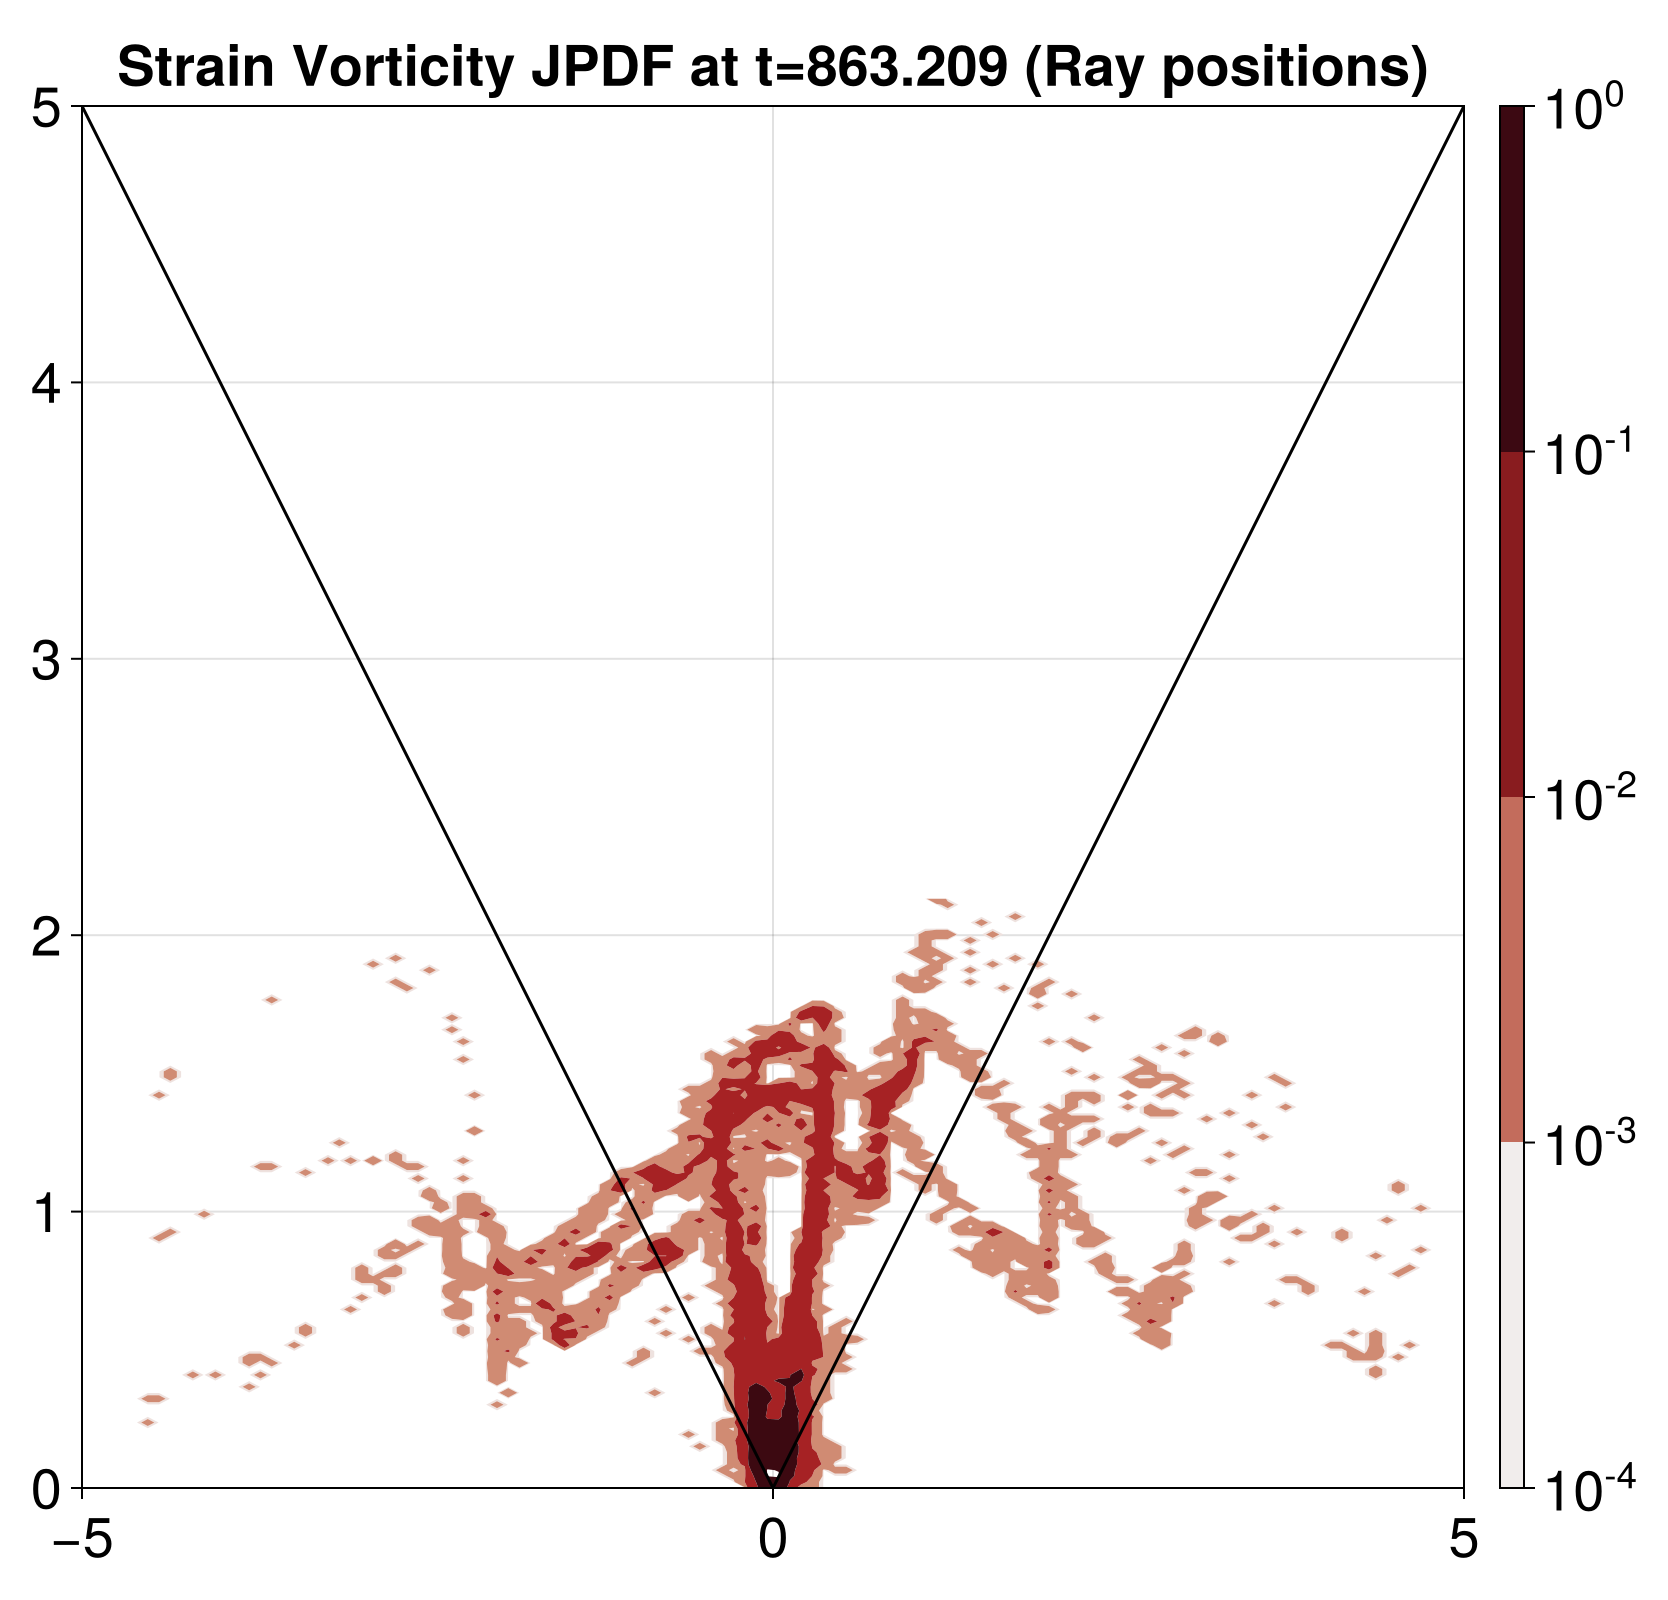

In [5]:
ζ_bins = 200
σ_bins = 100
max_ζ = maximum(abs.(ζ))
max_σ = maximum(σ)
max_limit = 5 #max(max_ζ, max_σ)
println(max_ζ)
println(max_σ)
bin_counts = zeros(ζ_bins, σ_bins)
ζ_idx = min.(floor.(Int, (ζ .+ max_ζ) / (2 * max_ζ) * ζ_bins) .+ 1, ζ_bins)
σ_idx = min.(floor.(Int, σ / max_σ * σ_bins) .+ 1, σ_bins)
for i=1:length(ζ)
    bin_counts[ζ_idx[i], σ_idx[i]] += 1
end
bin_counts /= length(ζ)
bin_counts *= (2π)^2

ζs = (0:(ζ_bins-1))/(ζ_bins-1) * 2 * max_ζ .- max_ζ
σs = (0:(σ_bins-1))/(σ_bins-1) * max_σ

f = Figure(size=(800, 800), fontsize=28)
ax = Axis(f[1,1]; title=@sprintf("Strain Vorticity JPDF at t=%0.3f (Ray positions)", t),
    limits=((-max_limit, max_limit), (0, max_limit)))
ctr = contourf!(ax, ζs, σs,  bin_counts, 
    levels = 10.0.^(-4:0),
    colormap=:amp, colorscale=log10)
colsize!(f.layout, 1, Aspect(1,1.0))
ablines!(ax, [0, 0], [1, -1], color=:black)
cbar = Colorbar(f[1,2], ctr, ticks=10. .^(-4:0), 
    tickformat=values -> [rich("10", superscript(string(Int(log10(value)))))  for value in values])
resize_to_layout!(f)
save(@sprintf("rays_strain_vorticity_jpdf_idx=%d.png", packet_idx), f)
f

In [6]:
N_packet_samples = 200
Npackets = 128^2
packet_idxs = (shuffle(1:Npackets))[1:N_packet_samples]
t_array = zeros(Nsnapshots-1)
gradient_array = zeros(Nsnapshots-1, N_packet_samples, 4)
velocity_array = zeros(Nsnapshots-1, N_packet_samples, 2)
position_array = zeros(Nsnapshots-1, N_packet_samples, 2)
wavenumber_array = zeros(Nsnapshots-1, N_packet_samples, 2)
for idx=2:Nsnapshots
    (t, x, k, u, ∇u) = load_snapshot(data_directory, idx; load_gradients=true)
    t_array[idx-1] = t
    gradient_array[idx-1, :, :] .= ∇u[packet_idxs, :]
    velocity_array[idx-1, :, :] .= u[packet_idxs, :]
    position_array[idx-1, :, :] .= x[packet_idxs, :]
    wavenumber_array[idx-1, :, :] .= k[packet_idxs, :]
end

In [7]:
ζt  = gradient_array[:,:,3] - gradient_array[:,:,2]
σnt = gradient_array[:,:,1] - gradient_array[:,:,4]
σst = gradient_array[:,:,3] + gradient_array[:,:,2]
σt = sqrt.(σnt.^2 + σst.^2)

2221×200 Matrix{Float64}:
 0.686739   0.578989    0.696124   …  0.28895    0.148305   0.480547
 0.922657   0.357404    1.38779       0.0610379  0.302259   1.31282
 0.865536   0.214038    0.981584      0.113608   0.604916   0.307682
 0.585318   0.0683412   0.575334      0.128816   1.10903    0.17589
 1.07566    0.157006    0.609944      0.12376    0.461259   0.186871
 0.999966   0.656568    0.158938   …  0.0917744  0.470827   0.332406
 0.551731   1.8406      0.128772      0.0810342  1.06678    0.286632
 0.391884   1.14323     0.0946353     0.294416   0.579862   0.497674
 0.809097   0.338937    0.0570997     0.249359   0.388002   0.356194
 0.859712   0.0883781   0.133937      0.997323   0.136642   0.130845
 1.12729    0.442554    0.0899259  …  0.167776   0.117835   0.393988
 1.01279    0.264271    0.23655       1.23549    0.153525   0.353881
 0.952734   1.69831     0.242439      1.38963    0.237115   0.107978
 ⋮                                 ⋱                        
 1.46776    0.0104

In [8]:
ray_fig = Figure()
ax = Axis(ray_fig[1,1])
#lines!(t_array, σt[:,1])
#lines!(t_array, ζt[:,1])
cutoff_idx = 100
for i=1:N_packet_samples
    lines!(t_array[1:cutoff_idx], σt[1:cutoff_idx,i].^2 - ζt[1:cutoff_idx,i].^2)
end
ray_fig

LoadError: UndefVarError: `σt` not defined

In [8]:
function running_average(data, window_size)
    total_sum=zeros(length(data) - window_size + 1)
    for i=1:window_size
        total_sum += data[i:(end-window_size+i)]
    end
    return total_sum / window_size
end

running_average (generic function with 1 method)

In [32]:
wave_angle = atan.(wavenumber_array[:,:,2], wavenumber_array[:,:,1])
vel_angle = atan.(velocity_array[:,:,2], velocity_array[:,:,1])
difference = vel_angle - wave_angle
window_size = 5
window_size2 = 40
avg_difference = running_average.(eachcol(difference), window_size)
avg_difference2 = running_average.(eachcol(difference), window_size2)
avg_time = running_average(t_array, window_size)
avg_time2 = running_average(t_array, window_size2)

2182-element Vector{Float64}:
  234.03419876098633
  235.3673324584961
  236.70025901794435
  238.03297843933106
  239.36549072265626
  240.69779586791992
  242.02989387512207
  243.3617847442627
  244.6934684753418
  246.0249450683594
  247.35621452331543
  248.68727684020996
  250.01813201904298
    ⋮
 3110.905517578125
 3112.231201171875
 3113.556884765625
 3114.882568359375
 3116.208251953125
 3117.533935546875
 3118.859619140625
 3120.185302734375
 3121.510986328125
 3122.836669921875
 3124.162353515625
 3125.488037109375

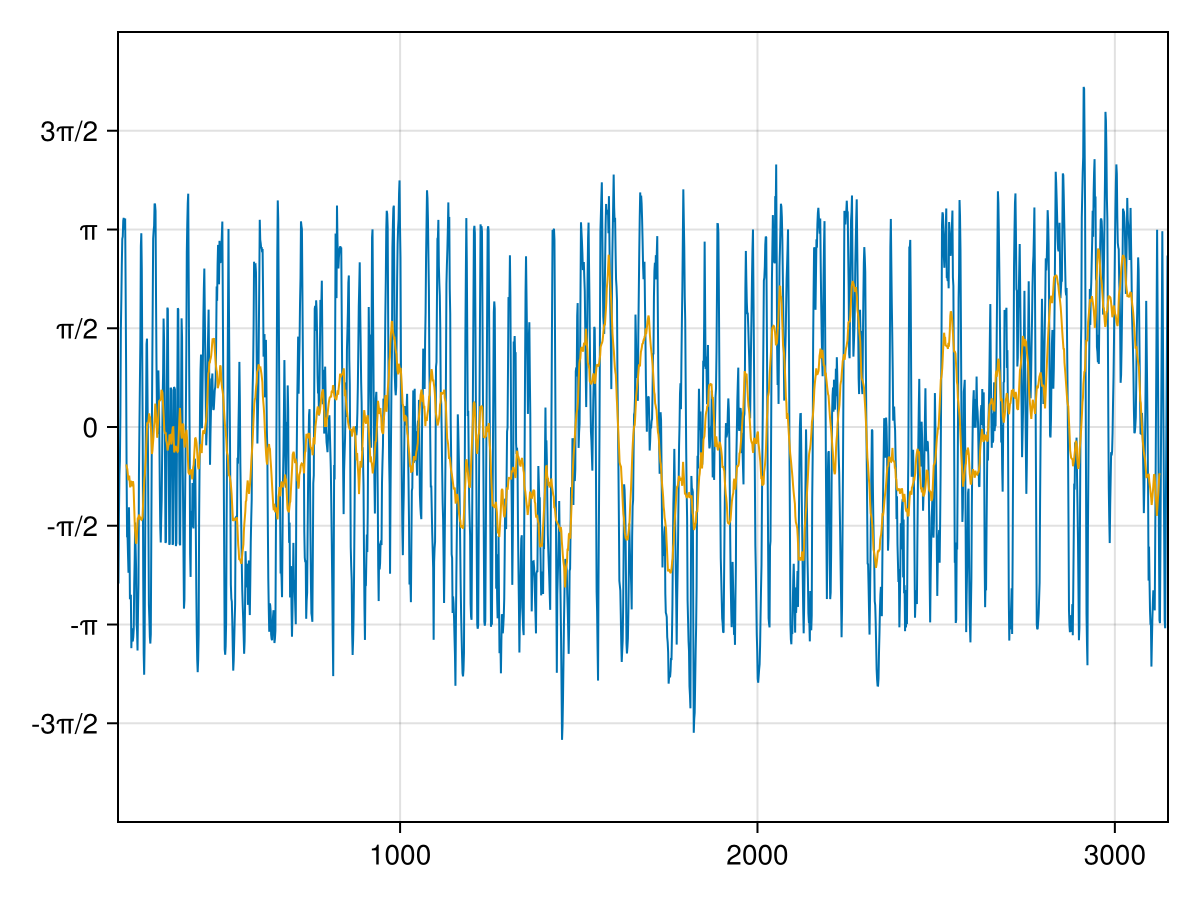

In [33]:
f = Figure()
ax = Axis(f[1,1]; limits=((avg_time[1], avg_time[end]), (-2π, 2π)),
    yticks=([-3π/2, -π, -π/2, 0, π/2, π, 3π/2], ["-3π/2", "-π", "-π/2", "0", "π/2", "π", "3π/2"]))
for i=1:1
    #lines!(ax, t_array[time_idx], wave_angle[time_idx,i], color=Cycled(i), linestyle=(:dot), linewidth=4)
    #lines!(ax, sol.t, pos_angle[:,i], color=Cycled(i), linestyle=:solid, linewidth=2)
    #lines!(ax, t_array[time_idx], vel_angle[time_idx,i], color=Cycled(i), linestyle=(:dash), linewidth=2)
    lines!(ax, avg_time, avg_difference[i], color=Cycled(i), linestyle=(:solid), linewidth=1)
    lines!(ax, avg_time2, avg_difference2[i], color=Cycled(i+1), linestyle=(:solid), linewidth=1)
end
f

In [76]:
Nqgsw_snapshots = count_qgsw_snapshots(data_directory)
packet_idx = 496
(t, x, k, u, ∇u) = load_snapshot(data_directory, packet_idx; load_gradients=true)
pos_angle = atan.(x[:,2], x[:,1])
vel_angle = atan.(u[:,2], u[:,1])
k_angle   = atan.(k[:,2], k[:,1])
doppler = u[:,1].*k[:,1] + u[:,2].*k[:,2]
wave_mag = sqrt.(k[:,1].^2 + k[:,2].^2)
vel_mag  = sqrt.(u[:,1].^2 + u[:,2].^2)
cos_doppler_angle = doppler ./ wave_mag ./ vel_mag
doppler_angle = acos.(cos_doppler_angle)

;

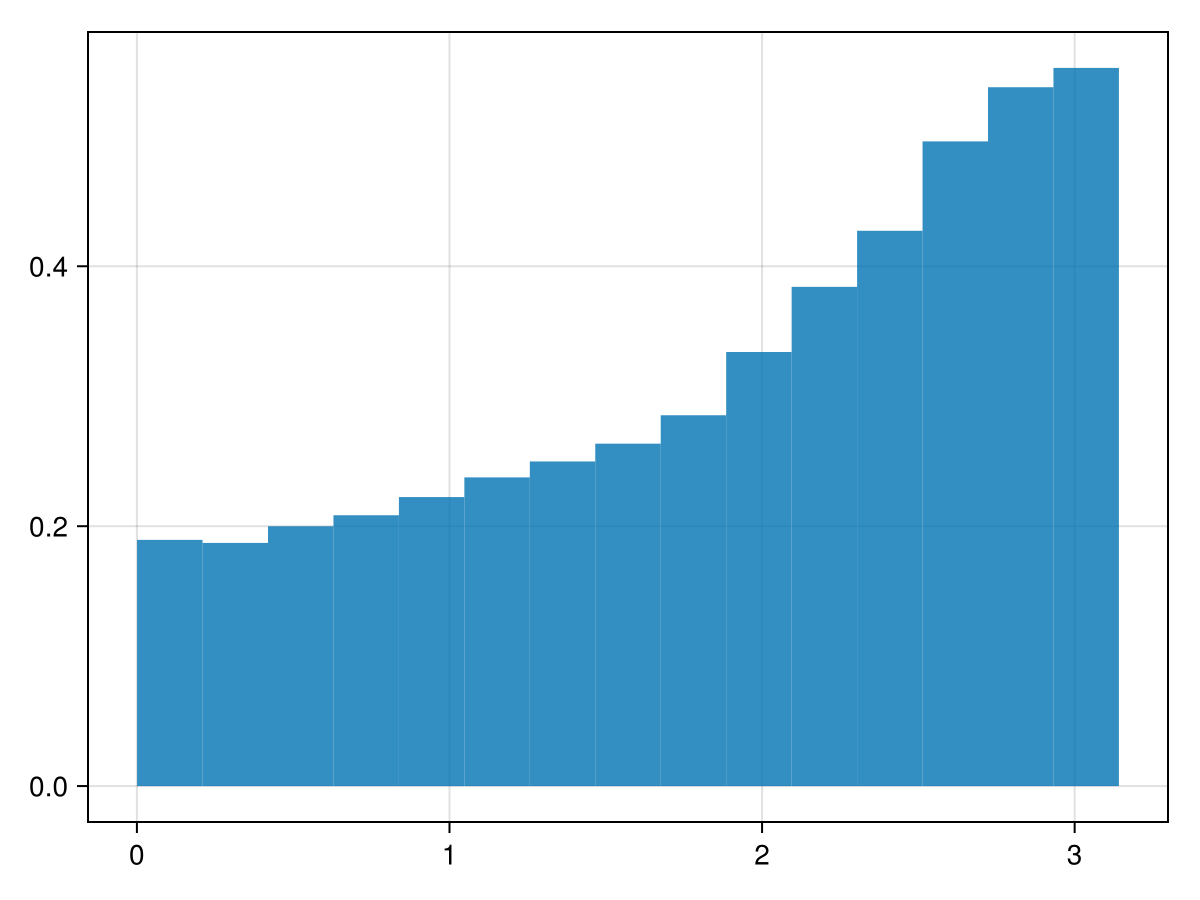

In [77]:
hist(doppler_angle, normalization=:pdf)

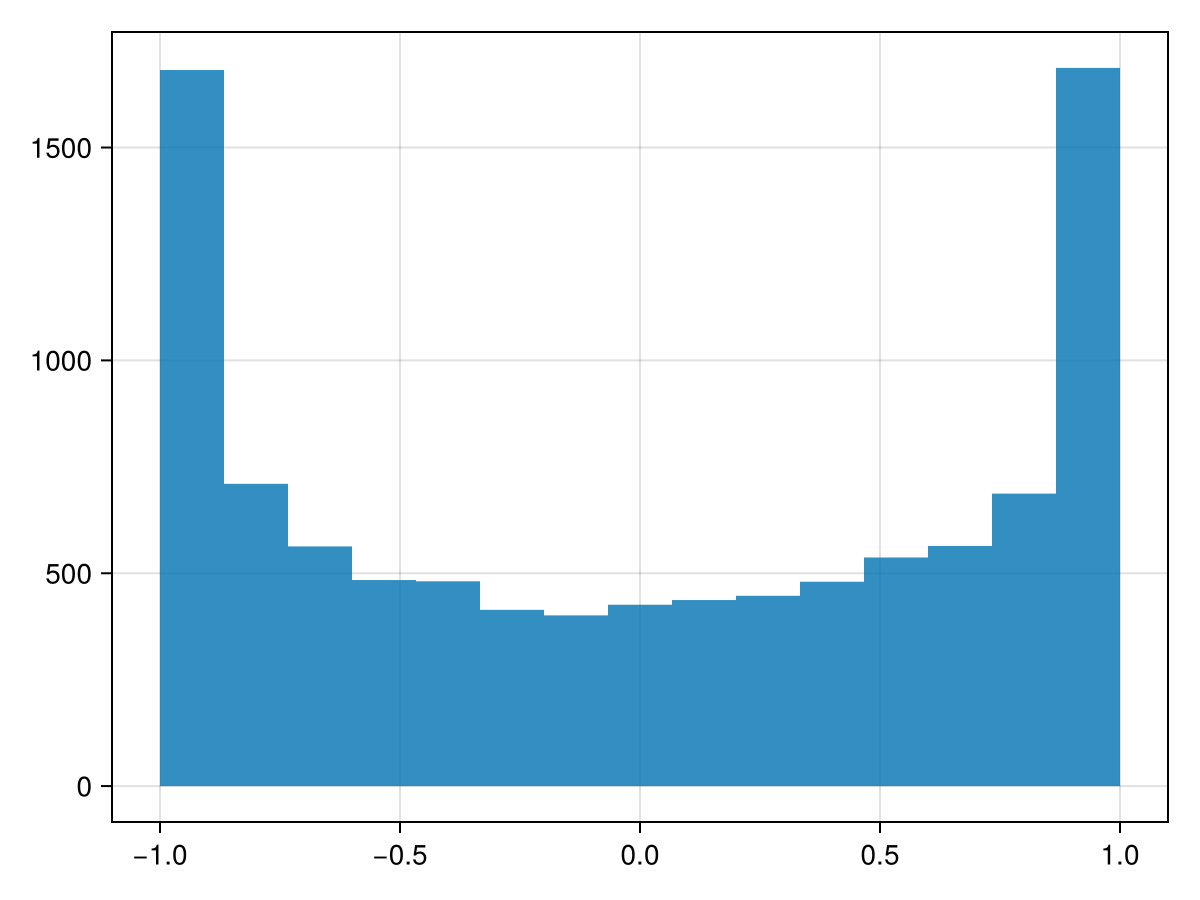

In [72]:
test_angle = 2π*rand(10000)
hist(cos.(test_angle))